### Import library

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from tqdm import tqdm
from time import sleep

from PIL import Image
from basic_image_eda import BasicImageEDA # https://github.com/Soongja/basic-image-eda
from skimage.color import rgb2lab, lab2rgb

import glob
import torch
from torch import nn, optim
from torchvision import transforms
from torchvision import transforms
from torchvision.utils import make_grid
from torch.utils.data import Dataset, DataLoader

from pathlib import Path
from itertools import islice


##  EDA

We will use the ImageNet dataset. The dataset contains 1.2 million images of 1000 different classes (although it's not needed for the colorization problem). The dataset is available for download [here](https://www.kaggle.com/c/imagenet-object-localization-challenge/overview/description). The dataset is organized in the following way:

In [ ]:
# Show the directory structure
space =  '    '
branch = '│   '
tee =    '├── '
last =   '└── '

def tree(dir_path: Path, level: int=-1, limit_to_directories: bool=False,
         length_limit: int=1000):
    """Given a directory Path object print a visual tree structure"""
    dir_path = Path(dir_path) # accept string coerceable to Path
    files = 0
    directories = 0
    def inner(dir_path: Path, prefix: str='', level=-1):
        nonlocal files, directories
        if not level: 
            return # 0, stop iterating
        if limit_to_directories:
            contents = [d for d in dir_path.iterdir() if d.is_dir()]
        else: 
            contents = list(dir_path.iterdir())
        pointers = [tee] * (len(contents) - 1) + [last]
        for pointer, path in zip(pointers, contents):
            if path.is_dir():
                yield prefix + pointer + path.name
                directories += 1
                extension = branch if pointer == tee else space 
                yield from inner(path, prefix=prefix+extension, level=level-1)
            elif not limit_to_directories:
                yield prefix + pointer + path.name
                files += 1
    print(dir_path.name)
    iterator = inner(dir_path, level=level)
    for line in islice(iterator, length_limit):
        print(line)
    if next(iterator, None):
        print(f'... length_limit, {length_limit}, reached, counted:')
    print(f'\n{directories} directories' + (f', {files} files' if files else ''))

tree(r'D:\data\imagenet-object-localization-challenge\ILSVRC', level=3, limit_to_directories=True)


ILSVRC
├── Annotations
│   └── CLS-LOC
│       ├── train
│       └── val
├── Data
│   └── CLS-LOC
│       ├── test
│       ├── train
│       └── val
└── ImageSets
    └── CLS-LOC

11 directories


In [ ]:
tree(r"D:\data\archive", level=1, limit_to_directories=True)

archive
├── clip_img
├── matting
└── matting_human_half

3 directories


### Image path

We use glob to retrieve all pathnames of the images

In [ ]:
# Retrieve the image paths
train_path = r"D:\data\imagenet-object-localization-challenge\ILSVRC\Data\CLS-LOC\train"
val_path = r"D:\data\imagenet-object-localization-challenge\ILSVRC\Data\CLS-LOC\val"
test_path = r"D:\data\imagenet-object-localization-challenge\ILSVRC\Data\CLS-LOC\test"
train_img_paths = glob.glob(train_path + "/**/*.jpeg", recursive=True)
val_img_paths = glob.glob(val_path + "/**/*.JPEG", recursive=True)
test_img_paths = glob.glob(test_path + "/**/*.JPEG", recursive=True)


KeyboardInterrupt: 

In [ ]:
human_path = r"D:\data\archive\clip_img"
human_img_paths = glob.glob(human_path + "/**/*.jpg", recursive=True)

In [ ]:
print(len(human_img_paths))

34425


In [ ]:
from sklearn.model_selection import train_test_split
train_paths, val_test_paths = train_test_split(human_img_paths, test_size=0.2, random_state=42)
val_paths, test_paths = train_test_split(val_test_paths, test_size=0.5, random_state=42)
print("train images:", len(train_paths))
print("val images:", len(val_paths))
print("test images:", len(test_paths))

train images: 27540
val images: 3442
test images: 3443



found 34425 images.
Using 12 threads. (max:12)



100%|██████████| 34425/34425 [10:35<00:00, 54.17it/s]



*--------------------------------------------------------------------------------------*
number of images                         |  34425

dtype                                    |  uint8
channels                                 |  [3]
extensions                               |  ['jpg']

min height                               |  800
max height                               |  800
mean height                              |  800.0
median height                            |  800

min width                                |  600
max width                                |  600
mean width                               |  600.0
median width                             |  600

mean height/width ratio                  |  1.3333333333333333
median height/width ratio                |  1.3333333333333333
recommended input size(by mean)          |  [800 600] (h x w, multiples of 8)
recommended input size(by mean)          |  [800 608] (h x w, multiples of 16)
recommended input size(by mean)    

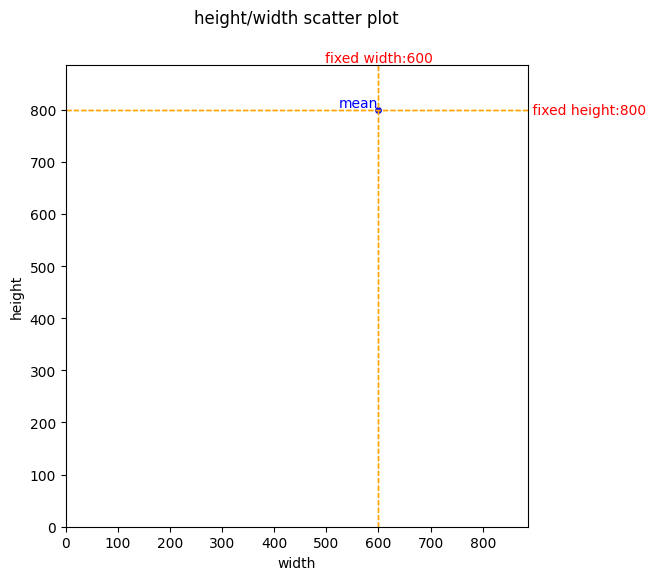

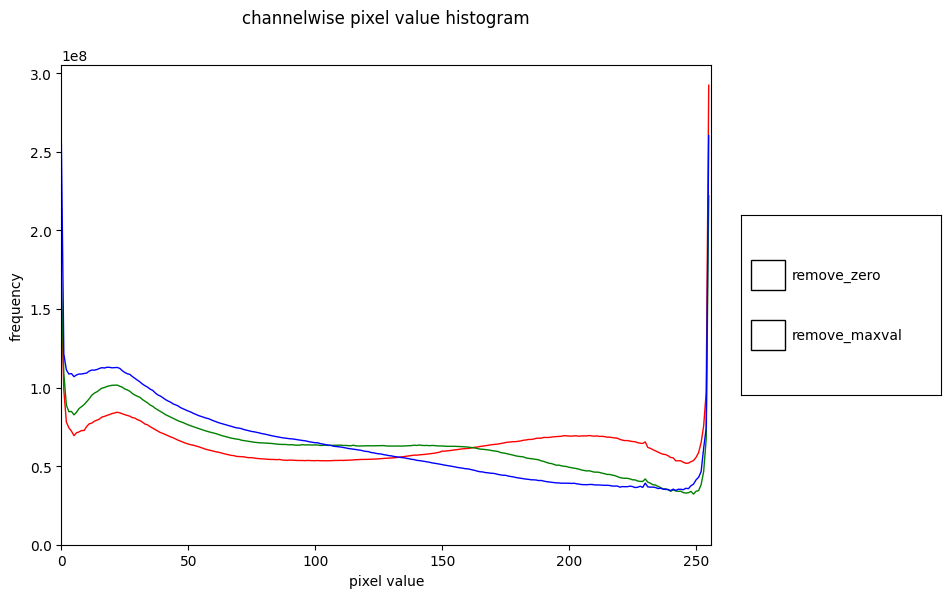

{'dtype': 'uint8',
 'channels': [3],
 'extensions': ['jpg'],
 'min_h': 800,
 'max_h': 800,
 'mean_h': 800.0,
 'median_h': 800,
 'min_w': 600,
 'max_w': 600,
 'mean_w': 600.0,
 'median_w': 600,
 'mean_hw_ratio': 1.3333333333333333,
 'median_hw_ratio': 1.3333333333333333,
 'rec_hw_size_8': array([800, 600]),
 'rec_hw_size_16': array([800, 608]),
 'rec_hw_size_32': array([800, 608]),
 'mean': array([0.49372652, 0.43179867, 0.399473  ], dtype=float32),
 'std': array([0.30543014, 0.28910547, 0.29297805], dtype=float32)}

In [ ]:
extensions = ['jpg']
threads = 0
dimension_plot = True
channel_hist = True
nonzero = False
hw_division_factor = 1.0
BasicImageEDA.explore(human_path, extensions, threads, dimension_plot, channel_hist, nonzero, hw_division_factor)

The number of images of each set

In [ ]:
print("train images: ", len(train_img_paths))
print("val images: ", len(val_img_paths))
print("test images: ", len(test_img_paths))

train images:  1281167
val images:  50000
test images:  100000


In [ ]:
def get_dims(file):
    """Opening the image file and converting it to an array. Then it is getting the height, width, and depth of the image.

    Args:
        file (_type_): _description_
    Returns:
        _type_: _description_
    """
    im = Image.open(file)
    arr = np.array(im)
    h,w,d = arr.shape
    return h,w

Explore the dataset with BasicImageEDA package


found 1281167 images.
Using 12 threads. (max:12)



100%|██████████| 1281167/1281167 [6:42:44<00:00, 53.02it/s]    



*--------------------------------------------------------------------------------------*
number of images                         |  1281167

dtype                                    |  uint8
channels                                 |  [1, 3, 4]
extensions                               |  ['JPEG']

min height                               |  10
max height                               |  6530
mean height                              |  405.5081991652923
median height                            |  375

min width                                |  8
max width                                |  9331
mean width                               |  472.9900777962592
median width                             |  500

mean height/width ratio                  |  0.8573291876536261
median height/width ratio                |  0.75
recommended input size(by mean)          |  [408 472] (h x w, multiples of 8)
recommended input size(by mean)          |  [400 480] (h x w, multiples of 16)
recommended input

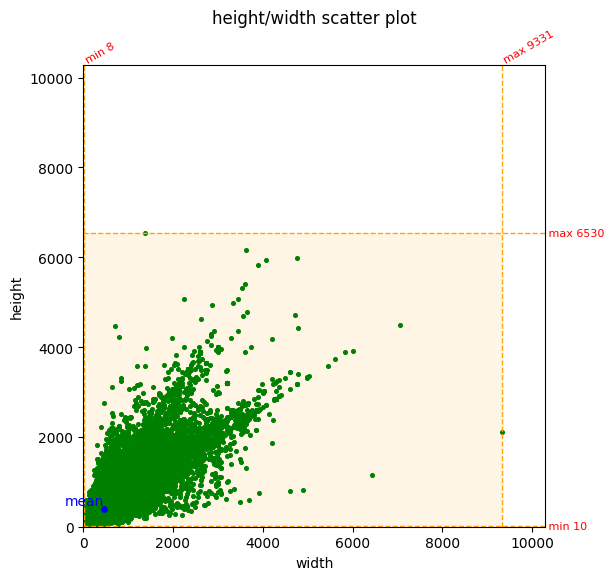

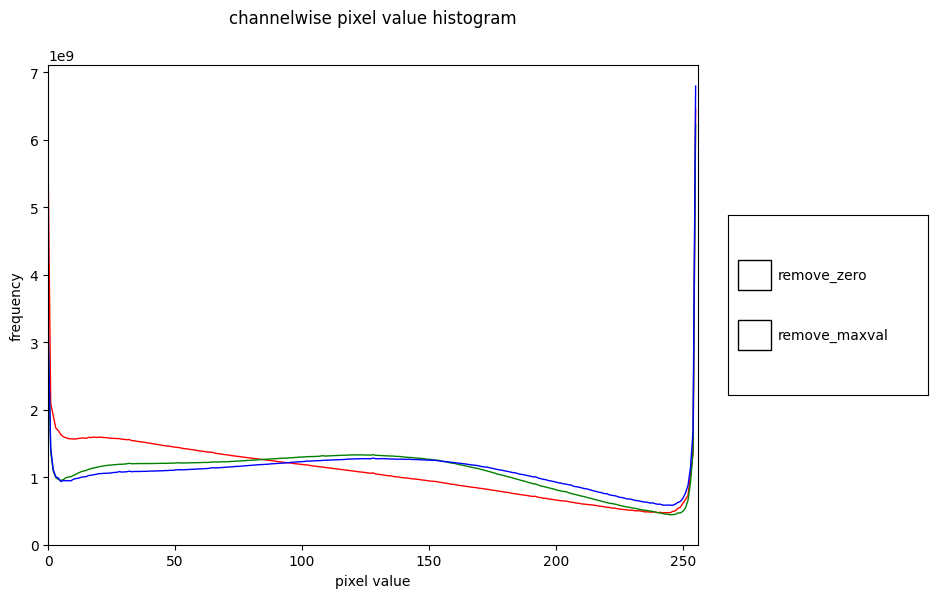

{'dtype': 'uint8',
 'channels': [1, 3, 4],
 'extensions': ['JPEG'],
 'min_h': 10,
 'max_h': 6530,
 'mean_h': 405.5081991652923,
 'median_h': 375,
 'min_w': 8,
 'max_w': 9331,
 'mean_w': 472.9900777962592,
 'median_w': 500,
 'mean_hw_ratio': 0.8573291876536261,
 'median_hw_ratio': 0.75,
 'rec_hw_size_8': array([408, 472]),
 'rec_hw_size_16': array([400, 480]),
 'rec_hw_size_32': array([416, 480]),
 'mean': array([0.40778415, 0.45743027, 0.48104194]),
 'std': array([0.289686  , 0.27622591, 0.2833912 ])}

In [ ]:
extensions = ['jpeg']
threads = 0
dimension_plot = True
channel_hist = True
nonzero = False
hw_division_factor = 1.0
BasicImageEDA.explore(train_path, extensions, threads, dimension_plot, channel_hist, nonzero, hw_division_factor)


found 50000 images.
Using 12 threads. (max:12)



100%|██████████| 50000/50000 [12:27<00:00, 66.85it/s] 



*--------------------------------------------------------------------------------------*
number of images                         |  50000

dtype                                    |  uint8
channels                                 |  [1, 3]
extensions                               |  ['JPEG']

min height                               |  56
max height                               |  5005
mean height                              |  430.25888
median height                            |  375

min width                                |  54
max width                                |  4288
mean width                               |  490.38648
median width                             |  500

mean height/width ratio                  |  0.8773873211186409
median height/width ratio                |  0.75
recommended input size(by mean)          |  [432 488] (h x w, multiples of 8)
recommended input size(by mean)          |  [432 496] (h x w, multiples of 16)
recommended input size(by mean)      

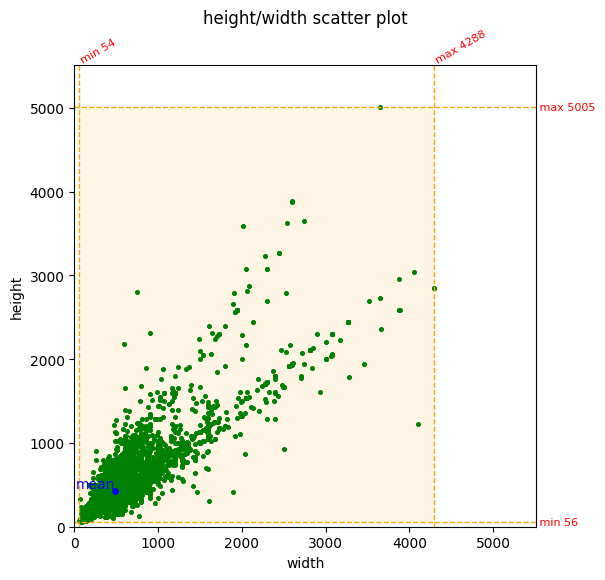

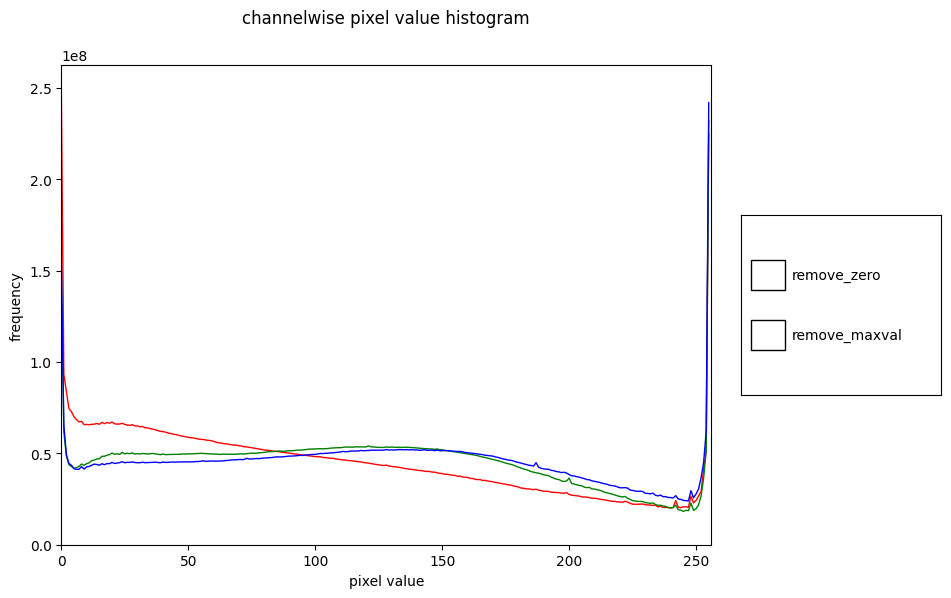

{'dtype': 'uint8',
 'channels': [1, 3],
 'extensions': ['JPEG'],
 'min_h': 56,
 'max_h': 5005,
 'mean_h': 430.25888,
 'median_h': 375,
 'min_w': 54,
 'max_w': 4288,
 'mean_w': 490.38648,
 'median_w': 500,
 'mean_hw_ratio': 0.8773873211186409,
 'median_hw_ratio': 0.75,
 'rec_hw_size_8': array([432, 488]),
 'rec_hw_size_16': array([432, 496]),
 'rec_hw_size_32': array([416, 480]),
 'mean': array([0.40106878, 0.45012876, 0.47294503], dtype=float32),
 'std': array([0.28790507, 0.27522925, 0.2819855 ], dtype=float32)}

In [ ]:
BasicImageEDA.explore(val_path, extensions, threads, dimension_plot, channel_hist, nonzero, hw_division_factor)


found 100000 images.
Using 12 threads. (max:12)



100%|██████████| 100000/100000 [32:56<00:00, 50.59it/s] 



*--------------------------------------------------------------------------------------*
number of images                         |  100000

dtype                                    |  uint8
channels                                 |  [1, 3]
extensions                               |  ['JPEG']

min height                               |  46
max height                               |  5616
mean height                              |  430.03926
median height                            |  375

min width                                |  44
max width                                |  4752
mean width                               |  490.67573
median width                             |  500

mean height/width ratio                  |  0.8764225204291234
median height/width ratio                |  0.75
recommended input size(by mean)          |  [432 488] (h x w, multiples of 8)
recommended input size(by mean)          |  [432 496] (h x w, multiples of 16)
recommended input size(by mean)     

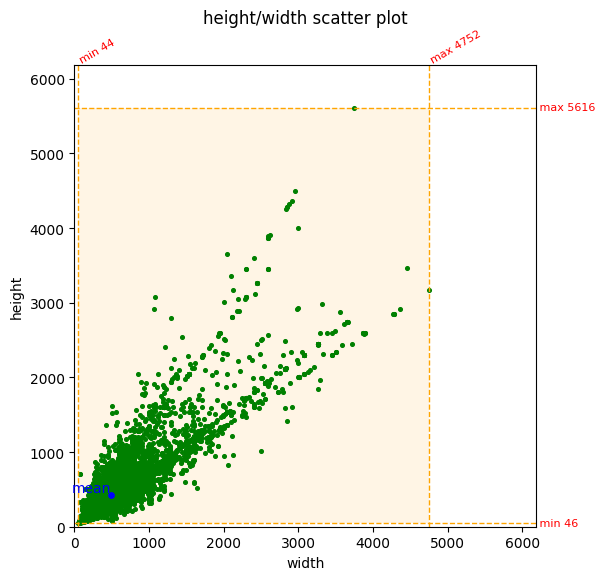

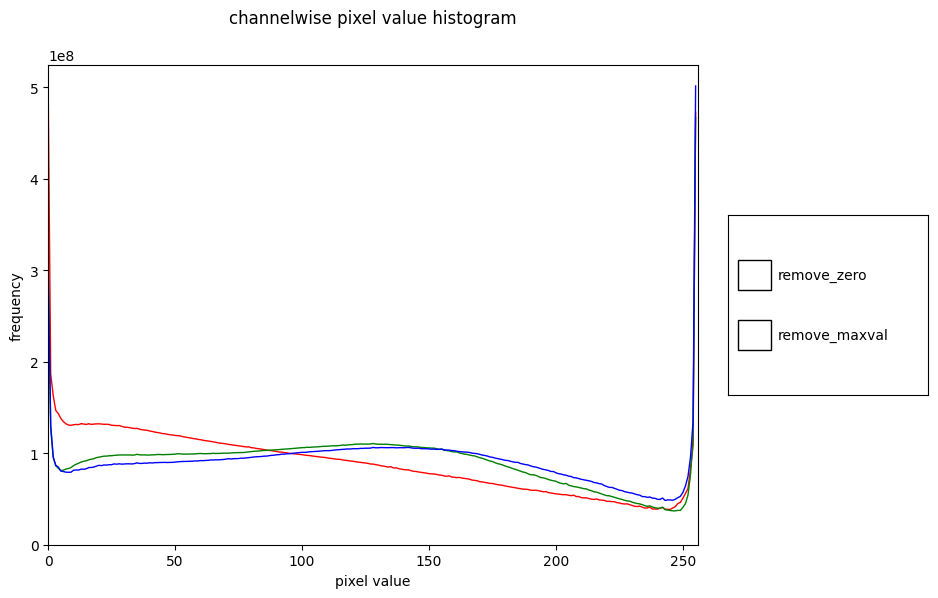

{'dtype': 'uint8',
 'channels': [1, 3],
 'extensions': ['JPEG'],
 'min_h': 46,
 'max_h': 5616,
 'mean_h': 430.03926,
 'median_h': 375,
 'min_w': 44,
 'max_w': 4752,
 'mean_w': 490.67573,
 'median_w': 500,
 'mean_hw_ratio': 0.8764225204291234,
 'median_hw_ratio': 0.75,
 'rec_hw_size_8': array([432, 488]),
 'rec_hw_size_16': array([432, 496]),
 'rec_hw_size_32': array([416, 480]),
 'mean': array([0.4009243 , 0.45119215, 0.47435094]),
 'std': array([0.28807724, 0.27551642, 0.2822851 ])}

In [ ]:
BasicImageEDA.explore(test_path, extensions, threads, dimension_plot, channel_hist, nonzero, hw_division_factor)

## Create a dataset class
Perform data processing with resizing and converting RGB to LAB color space

In [ ]:
SIZE = 256
class ColorizationDataset:
    def __init__(self, paths, split = 'train') -> None:
        # set self.transforms based on split type 
        if split == 'train':
            self.transforms = transforms.Compose([
                # Resize
                transforms.Resize((SIZE,SIZE), Image.Resampling.BICUBIC), 
                # Flip
                transforms.RandomHorizontalFlip(),  
            ])
        elif split == 'val':
            self.transforms = transforms.Resize((SIZE, SIZE), Image.Resampling.BICUBIC)
        self.split = split
        self.size = SIZE
        self.paths = paths
    
    def __getitem__(self, idx):
        img = Image.open(self.paths[idx].convert("RGB"))
        img = self.transforms(img)  
        img = np.array(img)
        img_lab = rgb2lab(img).astype("float32") # convert to lab color space and convert to float32
        img_lab = transforms.ToTensor()(img_lab)
        L = img_lab[[0], ...] # luminance channel (black and white) - [0~100] - this is what we will give to the network as input 
        ab = img_lab[[1, 2], ...] # color channels - [-128~127] - these are what we will predict with the network
        
        L = L / 50 - 1 # normalize L channel to [-1,1]
        ab = 2 * (ab + 128) / 255 - 1 # normalize ab channels to [-1,1]
        return {"L": L, "ab": ab}
    
    def __len__(self):
        "Returning the length of the dataset."
        return len(self.paths) 
    
def make_loader(batch_size=16, n_workers=4, pin_memory=True, **kwargs):
    ds = ColorizationDataset(**kwargs)
    loader = DataLoader(ds, batch_size=batch_size, num_workers=n_workers, pin_memory=pin_memory)
    for i in tqdm(loader):
        sleep(0.01)
    return loader
        

In [ ]:
train_dloader = make_loader(paths = train_paths,split = 'train')
val_dloader = make_loader(paths = val_paths, split = 'val')

data = next(iter(train_dloader))

c:\Users\ADMIN\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\transforms\transforms.py:332: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  warnings.warn(
  0%|          | 0/1722 [00:00<?, ?it/s]

In [ ]:
Ls, abs_ = data['L'], data['ab']
print(Ls.shape, abs_.shape)
print(len(train_dloader), len(val_dloader))

NameError: name 'data' is not defined

## U-Net generator
This code implements a U-Net to be the generator of the GAN. The U-Net is build from the middle part of it and adds down-sampling and up-sampling modules to the left and right of that middle modules respectively at every iteration until it reaches the input module and output module. 
<center> <img src="asset/unet.png" alt="unet" style="width: 800px; margin: auto" /></center> 
The blue rectangles show the order of which the related modules are built with the code. The U-Net we will build have 8 layers down which the 256x256 image will become 1x1 in the middle of the U-Net and then it gets up-sampled to produce a 256x256 with 2 channels (a and b in LAB color space)

In [ ]:
class UnetBlock(nn.Module):
    """A block of the U-Net architecture.

    Args:
        nn (_type_): _description_
    """
    def __init__(self, nf, ni, submodule=None, input_c=None, dropout=False, innermost=False, outermost=False):
        """Initialize the UnetBlock class.

        Args:
            nf (int): input channel
            ni (int): output channel
            submodule (_type_, optional): Submodel. Defaults to None.
            input_c (_type_, optional): _description_. Defaults to None.
            dropout (bool, optional): dropout. Defaults to False.
            innermost (bool, optional): _description_. Defaults to False.
            outermost (bool, optional): _description_. Defaults to False.
        """
        super.__init__()
        self.outermost = outermost
        if input_c is None: input_c = nf
        downconv = nn.Conv2d(input_c, ni, kernel_size=4, stride=2, padding=1, bias=False)
        downrelu = nn.LeakyReLU(0.2, inplace=True)
        downnorm = nn.BatchNorm2d(ni)
        uprelu = nn.relu(True)
        upnorm = nn.BatchNorm2d(nf)
        
        if outermost: 
            upconv = nn.ConvTranspose2d(ni*2, nf, kernel_size=4, stride=2, padding=1)
            down = [downconv]
            up = [uprelu, upconv, nn.Tanh()]
            model = down + [submodule] + up
        if innermost:
            upconv = nn.ConvTranspose2d(ni, nf, kernel_size=4, stride=2, padding=1, bias=False)
            down = [downrelu, downconv]
            up = [uprelu, upconv, upnorm]
            model = down + up
        else:
            upconv = nn.ConvTranspose2d(ni*2, nf, kernel_size=4, stride=2, padding=1, bias=False)
            down = [downrelu, downconv, downnorm]
            up = [uprelu, upconv, upnorm]
            if dropout: up += [nn.Dropout(0.5)]
            model = down + [submodule] + up
        self.model = nn.Sequential(*model)
    
    def forward(self, x):
        if self.outermost:
            return self.model(x)
        return torch.cat([x, self.model(x)], 1)
    
class Unet(nn.Module):
    """The U-Net architecture.

    Args:
        nn (_type_): _description_
    """
    def __init__(self, input_c=1, output_c=2, n_down=8, num_filters=64):
        super().__init__()
        # construct middle block
        unet_block = UnetBlock(num_filters * 8, num_filters * 8, innermost=True)
        for _ in range(n_down - 5):
            unet_block = UnetBlock(num_filters * 8, num_filters * 8, submodule=unet_block, dropout=True)
        out_filters = num_filters * 8
        for _ in range(3):
            unet_block = UnetBlock(out_filters // 2, out_filters, submodule=unet_block)
        self.model = UnetBlock(output_c, input_c, submodule=unet_block, outermost=True)
    def forward(self, x):
        return self.model(x)
            
        

## Discriminator
This model is built by stacking Conv-BatchNorm-LeakyRelu to decide whether the input image is fake or real. The first and last block has no activation function as it is embedded in the loss function

In [ ]:
class PatchDiscriminator(nn.Module):
    def __init__(self, input_c, num_filters=64, n_down=3):
        """Initialize the PatchDiscriminator class.

        Args:
            input_c (_type_): _description_
            num_filters (int, optional): _description_. Defaults to 64.
            n_down (int, optional): _description_. Defaults to 3.
        """
        super().__init__()
        model = [self.get_layers(input_c, num_filters, norm=False)]
        model += [self.get_layers(num_filters * 2 ** i,
                                  num_filters * 2 ** (i + 1),
                                  s=1 if i == n_down - 1 else 2) # stride = 1 for last layer of this loop
                  for i in range(n_down)]
        model += [self.get_layers(num_filters * 2 ** n_down, 1, s=1, norm=False, act=False)] # no norm/activation for last layer
    def get_layers(self, ni, nf, k=4, s=2, p=1, norm=True, act=True):
        """Get the layers of the discriminator.

        Args:
            ni (int): input channel
            nf (int): output channel
            k (int, optional): kernel. Defaults to 4.
            s (int, optional): stride. Defaults to 2.
            p (int, optional): padding. Defaults to 1.
            norm (bool, optional): append BatchNorm. Defaults to True.
            act (bool, optional): append activation function (LeakyRelu). Defaults to True.

        Returns:
            Sequential: Sequential layers 
        """
        layers = [nn.Conv2d(ni, nf, k, s, p, bias=not norm)]
        if norm: layers.append(nn.BatchNorm2d(nf))
        if act: layers.append(nn.LeakyReLU(0.2, inplace=True))
        return nn.Sequential(*layers)
    def forward(self, x):
        """Forward pass.

        Args:
            x (_type_): _description_

        Returns:
            _type_: _description_
        """
        return self.model(x)

Gan loss


In [ ]:
class GANLoss(nn.Module):
    def __init__(self, gan_mode = 'Patch', real_label = 1., fake_label = 0.):
        super().__init__()
        self.register_buffer('real_label', torch.tensor(real_label))
        self.register_buffer('fake_label', torch.tensor(fake_label))
        if gan_mode == 'patch': self.loss = nn.BCEWithLogitsLoss()
        elif gan_mode == 'lsgan': self.loss = nn.MSELoss()
    
    def get_labels(self, preds, target_is_real):
        """Get the labels for the discriminator.

        Args:
            preds (_type_): _description_
            target_is_real (_type_): _description_

        Returns:
            _type_: _description_
        """
        if target_is_real: labels = self.real_label
        else: labels = self.fake_label
        return labels.expand_as(preds)
    
    def __call__(self, preds, target_is_real):
        labels = self.get_labels(preds, target_is_real)
        loss = self.loss(preds, labels)
        return loss

In [ ]:
from keras.utils import img_to_array
img_list = []
for i in range(4):
    img_list.append(img_to_array(Image.open(train_img_paths[i])))
img_list = np.array(img_list, dtype='object')
print(img_list.shape)

(4,)


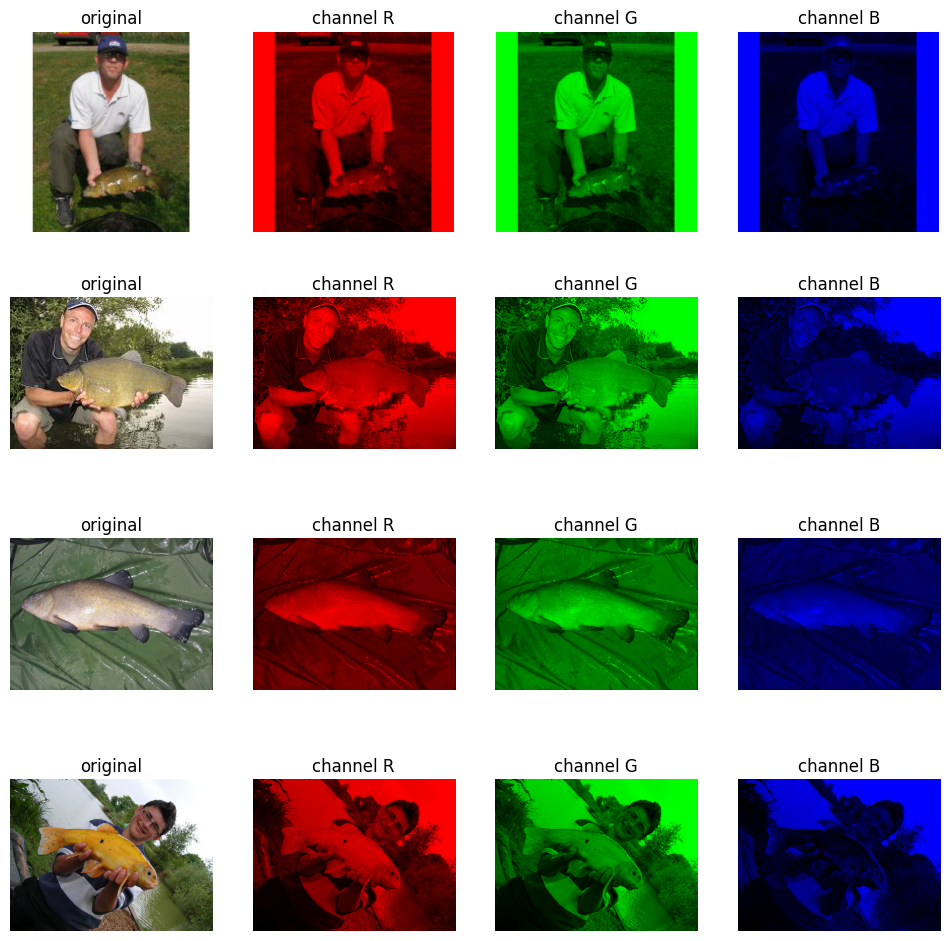

In [ ]:
from copy import copy
count = 1
fig = plt.figure(figsize=(12, 3*img_list.shape[0]))
# loop over the images in the list
for rgb in img_list:
    ax = fig.add_subplot(img_list.shape[0], 4, count)
    ax.imshow(rgb/255)
    ax.axis('off')
    ax.set_title('original')
    count += 1
    # plot the rgb channels
    for i, lab in enumerate('RGB'):
        crgb = np.zeros(rgb.shape)
        crgb[:, :, i] = rgb[:, :, i]
        ax = fig.add_subplot(img_list.shape[0], 4, count)
        ax.imshow(crgb/255)
        ax.axis('off')
        ax.set_title('channel {}'.format(lab))
        count += 1
plt.show()

In [ ]:
def plotMinMax(Xsub_rgb,labels=["R","G","B"]):
    print("______________________________")
    for i, lab in enumerate(labels):
        mi = np.min(Xsub_rgb[:,:,:,i])
        ma = np.max(Xsub_rgb[:,:,:,i])
        print("{} : MIN={:8.4f}, MAX={:8.4f}".format(lab,mi,ma))

In [ ]:
plotMinMax(img_list)

______________________________


IndexError: too many indices for array: array is 1-dimensional, but 4 were indexed

In [ ]:
img_list.shape

(4,)

In [ ]:
(img_list/255).shape

(4,)

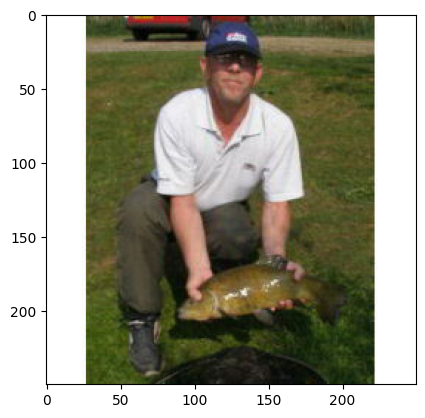

In [ ]:

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.imshow(img_list[0]/255)
plt.show()

In [ ]:
img_list_lab = rgb2lab(img_list/2)
def extract_lab(image, idim):
    z = np.zeros(image.shape)
    if idim != 0:
        z[:, :, 0] = 80
    z[:, :, idim] = image[:,:,idim]
    z = lab2rgb(z)
    return(z)
count = 1
fig = plt.figure(figsize=(12, 3*img_list.shape[0]))
for lab in  img_list_lab:
    ax = fig.add_subplot(img_list.shape[0], 3, count)
    lab_rgb_gray = extract_lab(lab, 0)
    print(lab_rgb_gray)
    ax.imshow(lab_rgb_gray)
    ax.axis('off')
    ax.set_title("L: lightness")
    count += 1
    
    ax = fig.add_subplot(img_list.shape[0], 3, count)
    lab_rgb_gray = extract_lab(lab, 1)
    ax.imshow(lab_rgb_gray)
    ax.axis('off')
    ax.set_title("a: green-red")
    count += 1
    
    ax = fig.add_subplot(img_list.shape[0], 3, count)
    lab_rgb_gray = extract_lab(lab, 2)
    ax.imshow(lab_rgb_gray)
    ax.axis('off')
    ax.set_title("b: blue-yellow")
    count += 1
    
plt.show()  
    

ValueError: the input array must have size 3 along `channel_axis`, got (4,)

# Model
